# Description
This notebook aims to download data from lending club and do a initial analysis

# Setup

In [1]:
import pandas as pd
import plotly.express as px
import re
import numpy as np
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import joblib

import findspark
import pyspark
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql import DataFrame
import pyspark.sql.functions as sql
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, QuantileDiscretizer

In [2]:
findspark.init()
sc = pyspark.SparkContext(appName="Test")
spark = SparkSession.builder.master("local[*]") \
                    .appName('test') \
                    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/09 09:28:52 WARN Utils: Your hostname, pop-os-note, resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface wlp2s0)
25/06/09 09:28:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/09 09:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
input_path = "../data/"
output_path = "../outputs/"

# Data

## raw data input
We'll read the csv file and save as parquet, being a more efficient data type

In [90]:
raw_df = spark.read\
.format("csv")\
.option("header", "True")\
.option("quote", '''"''')\
.option("escape", '''"''')\
.option("inferSchema", "True")\
.load("/home/neon/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

In [93]:
raw_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double 

In [91]:
raw_df.limit(5).show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+---

In [92]:
raw_df\
.groupBy("loan_status")\
.agg(count("id").alias("count"))\
.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076751|
|             Default|     40|
|     In Grace Period|   8436|
|         Charged Off| 268559|
|  Late (31-120 days)|  21467|
|             Current| 878317|
|   Late (16-30 days)|   4349|
|                NULL|     33|
|Does not meet the...|   1988|
|Does not meet the...|    761|
+--------------------+-------+



In [94]:
raw_df\
.write\
.mode("overwrite")\
.format("parquet")\
.save(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

## Read parquet

In [5]:
data = spark.read.parquet(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

In [ ]:
# data = pd.read_parquet(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

# Analysis

## Default Rate vs DIfferent features

In [ ]:
loan_status_display = data\
.groupBy("loan_status")\
.agg(count(col("id")).alias("count"))\
.orderBy("loan_status")\
.toPandas()

loan_status_display

,loan_status,count
0,None,33
1,Charged Off,268559
2,Current,878317
3,Default,40
4,Does not meet the credit policy. Status:Charge...,761
5,Does not meet the credit policy. Status:Fully ...,1988
6,Fully Paid,1076751
7,In Grace Period,8436
8,Late (16-30 days),4349
9,Late (31-120 days),21467


In [6]:
def withTarget(df: DataFrame):
    result = df\
    .withColumn("default_flag", 
                when(col("loan_status").isin(["Default", 
                                              "Charged Off", 
                                              "Does not meet the credit policy. Status:Charged Off"]),
                                              1)
                .when(col("loan_status").isin(["Fully Paid",
                                               "Does not meet the credit policy. Status:Fully Paid"]),
                                              0)
                .when(col("loan_status").isin(["Current",
                                               "In Grace Period",
                                               "Late (16-30 days)",
                                               "Late (31-120 days)"]),
                                             -1)
                .otherwise(-1))
    return result

def filterValidTargetValues(df: DataFrame):
    result = df\
    .where(col("default_flag").isin([1,0]))
    return result

def withDefaultRateGrouped(df: DataFrame, group_col: str):
    result = df
    if data.schema[group_col].dataType.simpleString() in ["double", "int"]:
        quantDisc = QuantileDiscretizer(inputCol=group_col, 
                                        outputCol=f'{group_col}_bands', 
                                        numBuckets=10, 
                                        handleInvalid="keep")
        
        w1 = Window.partitionBy(f'{group_col}_bands').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
        
        result = quantDisc\
                    .fit(result)\
                    .transform(result)\
                    .withColumn(group_col, 
                                concat(char(col(f'{group_col}_bands') + 97),
                                       lit(". "),
                                       min(col(group_col)).over(w1),
                                       lit("-"),
                                       max(col(group_col)).over(w1)))
    result = result\
    .groupBy(col(group_col).cast("string").alias("value"))\
    .agg((sum(col("default_flag")) / count(col("default_flag"))).alias("default_rate"),
         count(col("id")).alias("count"))\
    .withColumn("variable", lit(group_col))
    return result

def withDefaultRateGroupedMultipleColumns(df: DataFrame, group_cols: list):
    counter = 0
    for col_i in group_cols:
        if counter == 0:
            result = df.transform(withDefaultRateGrouped, col_i)
            counter = 1
        else:
            result = result\
            .unionByName(
                df.transform(withDefaultRateGrouped, col_i)
            )
    return result


data_target_filtered = data\
.transform(withTarget)\
.transform(filterValidTargetValues)

data_chart = data_target_filtered\
.transform(withDefaultRateGroupedMultipleColumns, 
           ["grade",
            "sub_grade", 
            "fico_range_low",
            "int_rate",
            "loan_amnt",
            "emp_length",
            "home_ownership",
            'annual_inc',
            'installment'])\
.toPandas()

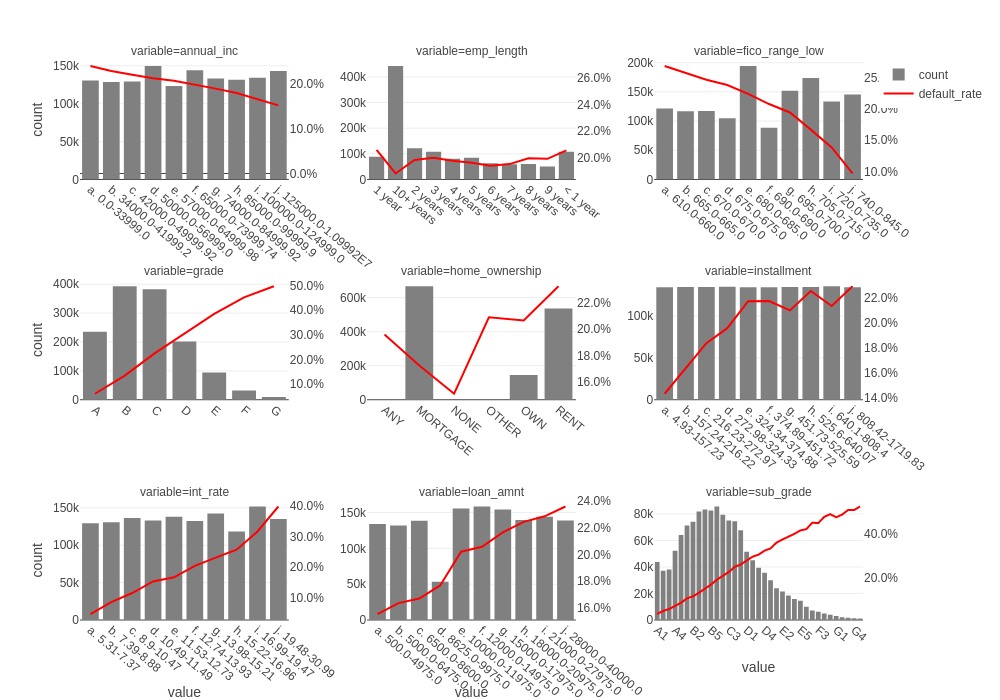

In [9]:
data_chart = data_chart.sort_values(["variable", "value"])
fig1 = px.line(data_chart,
              x='value',
              y='default_rate',
              facet_col="variable",
              facet_col_wrap=3,
              facet_col_spacing=0.1,
              template='none',
              color_discrete_sequence=['red'],
              category_orders={'variable':data_chart['variable'].drop_duplicates().sort_values()},
              width=700)
fig1.update_traces(name="default_rate", legendgroup="default_rate")
fig1.update_traces(selector={'xaxis':'x'}, showlegend=True)
fig1.update_xaxes(matches=None, showticklabels=True)
fig1.update_yaxes(matches=None, showticklabels=True)

fig2 = px.bar(data_chart,
              x='value',
              y='count',
              facet_col="variable",
              facet_col_wrap=3,
              facet_col_spacing=0.1,
              facet_row_spacing=0.18,
              template='none',
              color_discrete_sequence=['grey'],
              category_orders={'variable':data_chart['variable'].drop_duplicates().sort_values()},
              height=700,
              width=1000)
fig2.update_traces(name="count", legendgroup="count")
fig2.update_traces(selector={'xaxis':'x'}, showlegend=True)

for i, data_i in enumerate(fig1['data']):
    n = len(fig2['data'])+i+1
    y = f'y{n}'
    data_i['yaxis'] = y
    fig2.add_traces(data_i)
    fig2['layout'][f"yaxis{n}"] = {
        'anchor': fig2['data'][i]['xaxis'],
        'overlaying' : fig2['data'][i]['yaxis'],
        'side':'right',
        'tickformat':'0.1%',
        'showgrid':False
    }

fig2.update_xaxes(matches=None, showticklabels=True, tickangle=40)
fig2.update_yaxes(matches=None, showticklabels=True)
Image(fig2.to_image("png"))

## Null analysis

In [39]:
perc_nulls = data_target_filtered\
.select(
    [(count(when(F.col(c).isNull(), c)) / count(lit(1))).alias(c) for c in data_target_filtered.columns]
)\
.toPandas()

In [12]:
data_chart = perc_nulls.melt().sort_values("value", ascending=False)
fig = px.bar(
    data_chart,
    y='value',
    x='variable',
    template='none',
    title="Percentage of Null",
    width=700
)
fig.add_hline(y=0.05, annotation={'text':"5%"}, line={'dash':'dash', 'color':'green'})
fig.add_hline(y=0.4 , annotation={'text':"40%"}, line={'dash':'dash', 'color':'red'})
fig

In [7]:
def filterOutNullFeatures(df: DataFrame, threshold: float):
    columns_selected = df\
        .select(
            [(count(when(F.col(c).isNull(), c)) / count(lit(1))).alias(c) for c in df.columns]
        )\
        .melt(ids=[], values=[col_i for col_i in df.columns], valueColumnName='values', variableColumnName='variable')\
        .where(col("values")<=threshold)\
        .select(collect_list("variable"))\
        .first()[0]
    result = df.select(columns_selected)
    return result

data_nulls_excluded = data_target_filtered\
.transform(filterOutNullFeatures, 0.05)

string_select = []
for col in data_nulls_excluded.columns:
    string_select.append(f"CAST({col} AS STRING) AS {col}")

data_nulls_excluded\
.selectExpr(string_select)\
.melt(ids=[], values=[col for col in data_nulls_excluded.columns], variableColumnName="variable", valueColumnName="value")\
.drop_duplicates()\
.groupBy("variable")\
.agg(count("value").alias("n_values"))\
.orderBy("n_values")\
.show()

25/06/06 09:23:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------+
|            variable|n_values|
+--------------------+--------+
|         policy_code|       1|
|          pymnt_plan|       1|
|       hardship_flag|       1|
|    application_type|       2|
| initial_list_status|       2|
|                term|       2|
| disbursement_method|       2|
|        default_flag|       2|
|debt_settlement_flag|       2|
| verification_status|       3|
|         loan_status|       5|
|      home_ownership|       6|
|               grade|       7|
|      acc_now_delinq|       8|
|chargeoff_within_...|      11|
|pub_rec_bankruptcies|      12|
|             purpose|      14|
|collections_12_mt...|      15|
|      inq_last_6mths|      28|
|         delinq_2yrs|      31|
+--------------------+--------+
only showing top 20 rows


In [17]:
data_nulls_excluded\
.groupBy("pymnt_plan")\
.agg(count(lit(1)).alias("count"))\
.show()

+----------+-------+
|pymnt_plan|  count|
+----------+-------+
|         n|1348099|
+----------+-------+



In [66]:
data_nulls_excluded\
.write\
.mode("overwrite")\
.save(f"{output_path}accepted_2007_to2018Q2_treated.parquet")

In [5]:
data_nulls_excluded = spark.read.parquet(f"{output_path}accepted_2007_to2018Q2_treated.parquet")

In [5]:
data_pd = pd.read_parquet(f"{output_path}accepted_2007_to2018Q2_treated.parquet")

In [69]:
data_nulls_excluded.show()

+--------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+-------------------+--------+-----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------+-------------------+--------------------------+-----------+----------------+--------------+--------------------+--------------+-------+------------------------+-----------+--------+--------------------+-----------+--------+----------------+--------------------+---------+-----------------+--------------+-------------+-------------------+--------------------+------------+
|      id|l

In [70]:
data_nulls_excluded.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- 

## train / test split

In [94]:
train_df, test_df = data_nulls_excluded.randomSplit([0.6, 0.4], seed=42)

train_df\
    .write\
    .mode("overwrite")\
    .save(f"{output_path}raw_train.parquet")

test_df\
    .write\
    .mode("overwrite")\
    .save(f"{output_path}raw_test.parquet")

In [5]:
train_df = spark.read.parquet(f"{output_path}raw_train.parquet")
test_df = spark.read.parquet(f"{output_path}raw_test.parquet")

## binning and WoE

### Tree classifier

In [64]:
class TreeClassifierBinner:
    def __init__(self,
                 min_samples_split: float = 0.3,
                 max_leaf_nodes: int = 10):
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_split = min_samples_split
        self.avg_value = None
        self.clf = DecisionTreeClassifier(max_leaf_nodes=self.max_leaf_nodes, random_state=42)
        self.woe_schema = \
                StructType(
                            [StructField('type', StringType(), True), 
                            StructField('column', StringType(), True), 
                            StructField('splits', ArrayType(DoubleType(), True), True), 
                            StructField('min', DoubleType(), True), 
                            StructField('max', DoubleType(), True), 
                            StructField('clusters', ArrayType(StringType(), True), True), 
                            StructField('null_coalesce_col_value', StringType(), True), 
                            StructField('null_coalesce_woe', DoubleType(), True), 
                            StructField('bands', DoubleType(), True), 
                            StructField('woe', DoubleType(), True), 
                            StructField('iv', DoubleType(), True)]
                            )
    
    def fit(self, data: DataFrame, col_to_bin: str, target_col: str):
        self.col_to_bin = col_to_bin
        self.target_col = target_col
        if isinstance(data, DataFrame):
            pd_data = data.select(col_to_bin, target_col).toPandas()
            x = pd_data[[self.col_to_bin]]
            y = pd_data[self.target_col]
            self.clf.fit(x, y)
            self.univariate_thresholds = self.uniVariableDecisionTreeThresholds()
            self.calculateWoe(data)
        if isinstance(data, pd.DataFrame):
            pd_data = data.copy()
            x = pd_data[[self.col_to_bin]]
            y = pd_data[self.target_col]
            self.clf.fit(x, y)
            self.univariate_thresholds = self.uniVariableDecisionTreeThresholds()
            self.calculateWoePD(pd_data)
        return self

    def plot(self):
        tree.plot_tree(self.clf)
    
    def uniVariableDecisionTreeThresholds(self):
        self.text_tree = tree.export_text(self.clf, feature_names=[self.col_to_bin])
        result = str(self.text_tree)
        result = result.replace(f"{self.col_to_bin}", "")
        result = re.sub("class: [0-9]", "", result)
        result = re.sub("[^0-9., ]", "", result)
        result = re.sub(" +", ", ", result.strip()).split(", ")
        result = list(set([float(x) for x in result])) + [float("-inf"), float("+inf")]
        result.sort()
        return result
    
    def withBandsPD(self, df: pd.DataFrame):
        result = df.copy()
        if self.avg_value is None:
            self.avg_value = float(result[f'{self.col_to_bin}'].mean())
        result[f'{self.col_to_bin}_bands'] = pd.cut(result[self.col_to_bin].fillna(self.avg_value), self.univariate_thresholds, labels=False)
        return result
    
    def withBands(self, df: DataFrame):
        from pyspark.ml.feature import Bucketizer
        if self.avg_value is None:
            self.avg_value = df.agg(avg(self.col_to_bin).alias("avg")).select(collect_list("avg")).first()[0][0]
        result = df.withColumn(f"{self.col_to_bin}_temp", coalesce(col(self.col_to_bin), lit(self.avg_value)))
        
        # pd.cut have a left closed interval while bucketizer have a right closed interval, this adjusts the difference
        splits = [i + 0.000000001 for i in self.univariate_thresholds]

        bct = Bucketizer(splits=splits, 
                         inputCol=f"{self.col_to_bin}_temp", 
                         outputCol=f"{self.col_to_bin}_bands")
        result = bct.transform(result)\
                    .drop(f"{self.col_to_bin}_temp")
        return result

    def defaultRatesByGroupsPD(self, df):
        result = df.groupby([f'{self.col_to_bin}_bands'], observed=False)[self.target_col].agg(['count', 'sum'])
        result['total_count'] = result['count'].sum()
        result['m_rate'] = result['sum']/result['count']
        return result.reset_index()
    
    def defaultRatesByGroups(self, df: DataFrame):
        w1 = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

        result = df\
            .groupBy(f'{self.col_to_bin}_bands')\
            .agg(count(F.col(self.target_col)).alias("count"),
                 sum(F.col(self.target_col)).alias("sum"))\
            .withColumn("total_count", sum(F.col("count")).over(w1))\
            .withColumn("m_rate", F.col("sum") / F.col("count"))
        return result

    def calculateWoe(self, data: DataFrame):
        w1 = Window.orderBy('bands').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

        self.spark_woe  = data\
            .transform(self.withBands)\
            .transform(self.defaultRatesByGroups)\
            .withColumnRenamed(f'{self.col_to_bin}_bands','bands')\
            .withColumn("partition", lit(1))\
            .withColumn("non_defaults", F.col("count") - F.col("sum"))\
            .withColumn("total_defaults", sum(F.col("sum")).over(w1))\
            .withColumn("total_non_defaults", sum(F.col("non_defaults")).over(w1))\
            .withColumn("perc_defaults", greatest(least(F.col("sum") / F.col("total_defaults"), lit(0.99999)), lit(0.00001)))\
            .withColumn("perc_non_defaults", greatest(least(F.col("non_defaults") / F.col("total_non_defaults"), lit(0.99999)), lit(0.00001)))\
            .withColumn("woe", log(F.col("perc_defaults") / F.col("perc_non_defaults")))\
            .withColumn("iv", sum(-1*F.col("woe") * (F.col("perc_non_defaults") - F.col("perc_defaults"))).over(w1))\
            .withColumn("splits", lit(self.univariate_thresholds))\
            .withColumn("min", expr(f"GET(splits, CAST(bands AS INT))"))\
            .withColumn("max", expr(f"GET(splits, CAST(bands + 1 AS INT))"))\
            .withColumn("null_coalesce_col_value", lit(self.avg_value))\
            .withColumn("null_coalesce_woe", max(
                                                when(
                                                    (F.col("null_coalesce_col_value") >  F.col("min"))
                                                    & (F.col("null_coalesce_col_value") <=  F.col("max")),
                                                    F.col("woe"))).over(w1))\
            .withColumn("column", lit(self.col_to_bin))\
            .withColumn("type", lit("numeric"))\
            .withColumn("clusters", lit(None))\
            .select(
                "type",
                "column",
                "splits",
                "min",
                "max",
                "clusters",
                'null_coalesce_col_value',
                'null_coalesce_woe',
                'bands', 
                'woe', 
                'iv'
            )
        self.woe = self.spark_woe.toPandas()
        self.woe = self.woe.sort_values("bands").astype({"bands":"float"})
        self.is_monotonic = self.woe['woe'].is_monotonic_decreasing or self.woe['woe'].is_monotonic_increasing
        self.spark_woe = spark.createDataFrame(self.woe, schema = self.woe_schema)
        self.iv = self.woe['iv'][0]

    def calculateWoePD(self, data: pd.DataFrame):
        grouped_data = data\
            .pipe(self.withBandsPD)\
            .pipe(self.defaultRatesByGroupsPD)\
            .rename({f'{self.col_to_bin}_bands':'bands'}, axis='columns')
        grouped_data['non_defaults'] = grouped_data['count'] - grouped_data['sum']
        total_defaults = grouped_data['sum'].sum()
        total_non_defaults = grouped_data['non_defaults'].sum()
        grouped_data['perc_defaults'] = np.clip(grouped_data['sum']/ total_defaults, 0.00001, 0.99999)
        grouped_data['perc_non_defaults'] = np.clip(grouped_data['non_defaults']/ total_non_defaults, 0.00001, 0.99999)
        grouped_data['woe'] = np.log(grouped_data['perc_defaults'] / grouped_data['perc_non_defaults'])
        grouped_data['iv'] = np.sum(-grouped_data['woe'] * (grouped_data['perc_non_defaults'] - grouped_data['perc_defaults']))
        grouped_data = grouped_data.merge(pd.DataFrame({'splits':[self.univariate_thresholds]}), how='cross') 
        grouped_data['min'] = grouped_data['bands'].apply(lambda row: self.univariate_thresholds[row])
        grouped_data['max'] = grouped_data['bands'].apply(lambda row: self.univariate_thresholds[row+1])
        grouped_data['null_coalesce_col_value'] = self.avg_value
        grouped_data['null_coalesce_woe'] = pd.Series(np.where(
                                                          (grouped_data['null_coalesce_col_value'] > grouped_data['min'])
                                                        & (grouped_data['null_coalesce_col_value'] <= grouped_data['max']),
                                                        grouped_data['woe'], None
                                                        )
                                                    ).max()
        grouped_data['column'] = self.col_to_bin
        grouped_data['type'] = 'numeric'
        grouped_data['clusters'] = None
        self.woe = grouped_data[[
            "type",
            "column",
            "splits",
            "min",
            "max",
            "clusters",
            'null_coalesce_col_value',
            'null_coalesce_woe',
            'bands', 
            'woe', 
            'iv']]
        self.iv = self.woe['iv'][0]
        self.woe = self.woe.sort_values("bands").astype({"bands":"float"})
        self.is_monotonic = self.woe['woe'].is_monotonic_decreasing or self.woe['woe'].is_monotonic_increasing
        self.spark_woe = spark.createDataFrame(self.woe, schema = self.woe_schema)
        
    def addWoeColumnPD(self, df: pd.DataFrame, na_values=None):
        if self.woe is None:
            self.woe = self.spark_woe.toPandas()

        result = df.pipe(self.withBandsPD)
        result = result.merge(
            self.woe[['bands', 'woe']].rename({"bands":f'{self.col_to_bin}_bands'}, axis='columns'),
            how = 'left',
            on = f'{self.col_to_bin}_bands'
        )
        result = result.rename(columns={'woe':f'{self.col_to_bin}_woe'})
        if na_values:
            result[f'{self.col_to_bin}_woe'] = result[f'{self.col_to_bin}_woe'].fillna(na_values)
        return result
    
    def addWoeColumn(self, df: DataFrame, na_values=None):
        if self.spark_woe is None:
            spark_woe = spark.createDataFrame(self.woe)\
                                .withColumnRenamed("bands", f"{self.col_to_bin}_bands")
        else:   
            spark_woe = self.spark_woe\
                                .withColumnRenamed("bands", f"{self.col_to_bin}_bands")
            
        avg_woe = spark_woe.select(collect_list("null_coalesce_woe")).first()[0][0]
        result = df\
                .alias("a")\
                .join(broadcast(spark_woe.alias("b")), 
                      on=((F.col(f"a.{self.col_to_bin}")  > F.col("b.min"))
                         &(F.col(f"a.{self.col_to_bin}") <= F.col("b.max"))), 
                      how="left")\
                .withColumn(f"{self.col_to_bin}_woe", coalesce(F.col("woe"), lit(avg_woe)))\
                .drop("iv", 
                      'splits', 
                      'min', 
                      'max', 
                      'clusters',
                      'type',
                      'woe', 
                      'column', 
                      'null_coalesce_col_value', 
                      'null_coalesce_woe')
        return result
    
    def addWoeColumn2(self, df: DataFrame, na_values=None):
        from pyspark.ml.feature import Bucketizer
        if self.spark_woe is None:
            spark_woe = spark.createDataFrame(self.woe)\
                                .withColumnRenamed("bands", f"{self.col_to_bin}_bands")
        else:   
            spark_woe = self.spark_woe\
                                .withColumnRenamed("bands", f"{self.col_to_bin}_bands")
        
        splits = spark_woe.select(collect_list("splits")).first()[0][0]
        avg_col = spark_woe.select(collect_list("null_coalesce_col_value")).first()[0][0]

        result = df.withColumn(f"{self.col_to_bin}_temp", coalesce(col(self.col_to_bin), lit(avg_col)))
        
        # pd.cut have a left closed interval while bucketizer have a right closed interval, this adjusts the difference
        splits = [i + 0.000000001 for i in splits]

        bct = Bucketizer(splits=splits, 
                         inputCol=f"{self.col_to_bin}_temp", 
                         outputCol=f"{self.col_to_bin}_bands")
        
        result = bct.transform(result)\
                    .drop(f"{self.col_to_bin}_temp")
        
        result = result\
                .join(broadcast(spark_woe), 
                      on=[f"{self.col_to_bin}_bands"], 
                      how="left")\
                .drop("iv", 
                      'splits', 
                      'min', 
                      'max', 
                      'clusters',
                      'type',
                      'column', 
                      'null_coalesce_col_value', 
                      'null_coalesce_woe')\
                .withColumnRenamed("woe", f"{self.col_to_bin}_woe")
        return result
    

In [46]:
loan_amnt_woe = TreeClassifierBinner(max_leaf_nodes=5)
loan_amnt_woe.fit(train_df, "loan_amnt", "default_flag")

25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:02:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 1

In [47]:
loan_amnt_woe.spark_woe.orderBy("bands").show()

+-------+---------+--------------------+---------+--------+--------+-----------------------+-------------------+-----+--------------------+--------------------+
|   type|   column|              splits|      min|     max|clusters|null_coalesce_col_value|  null_coalesce_woe|bands|                 woe|                  iv|
+-------+---------+--------------------+---------+--------+--------+-----------------------+-------------------+-----+--------------------+--------------------+
|numeric|loan_amnt|[-Infinity, 9012....|-Infinity|  9012.5|    NULL|     14412.163431588731|0.05079318623589163|  0.0| -0.2589324649009251|0.034774280532417455|
|numeric|loan_amnt|[-Infinity, 9012....|   9012.5| 10012.5|    NULL|     14412.163431588731|0.05079318623589163|  1.0|-0.07557455533314127|0.034774280532417455|
|numeric|loan_amnt|[-Infinity, 9012....|  10012.5| 15012.5|    NULL|     14412.163431588731|0.05079318623589163|  2.0| 0.05079318623589163|0.034774280532417455|
|numeric|loan_amnt|[-Infinity, 901

In [48]:
loan_amnt_woe.is_monotonic

True

In [49]:
import time
start_time = time.time()

train_df\
.transform(loan_amnt_woe.addWoeColumn)\
.select("loan_amnt", "loan_amnt_bands", "loan_amnt_woe")\
.toPandas()

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

train_df\
.transform(loan_amnt_woe.addWoeColumn2)\
.select("loan_amnt", "loan_amnt_bands", "loan_amnt_woe")\
.toPandas()

print("--- %s seconds ---" % (time.time() - start_time))

--- 11.205574989318848 seconds ---


--- 11.463113069534302 seconds ---


### category classifier

In [65]:
class categoryClassifierBinner:
    def __init__(self,
                    n_splits:  int = 10,
                    n_samples: int = 10000,
                    n_groups:  int = 50):
        self.n_splits = n_splits
        self.n_samples = n_samples
        self.n_groups = n_groups
        self.woe_schema = \
                StructType(
                            [StructField('type', StringType(), True), 
                            StructField('column', StringType(), True), 
                            StructField('splits', ArrayType(DoubleType(), True), True), 
                            StructField('min', DoubleType(), True), 
                            StructField('max', DoubleType(), True), 
                            StructField('clusters', ArrayType(StringType(), True), True), 
                            StructField('null_coalesce_col_value', StringType(), True), 
                            StructField('null_coalesce_woe', DoubleType(), True), 
                            StructField('bands', DoubleType(), True), 
                            StructField('woe', DoubleType(), True), 
                            StructField('iv', DoubleType(), True)]
                            )

    def fit(self, data: DataFrame, col_to_bin: str, target_col: str):
        self.col_to_bin = col_to_bin
        self.target_col = target_col
        if isinstance(data, DataFrame):
            pd_data = data.select(col_to_bin, target_col).toPandas()
            self.applyKMeans(pd_data)
            self.calculateWoe(data)
        if isinstance(data, pd.DataFrame):
            pd_data = data[[col_to_bin, target_col]]
            self.applyKMeans(pd_data)
            self.calculateWoePD(pd_data)
        return self
    
    def applyKMeans(self, df: pd.DataFrame):
        from sklearn.cluster import KMeans
        sample = df\
        .pipe(self.withDFResampled, self.n_samples, self.n_groups)\
        .pipe(self.defaultRatesByGroupsPD, [self.col_to_bin, 'groups'])

        k_fold_sample = pd.pivot_table(sample, values='m_rate', index=self.col_to_bin, columns='groups').reset_index().set_index(self.col_to_bin)
        kmeans = KMeans(n_clusters=self.n_splits, random_state=42).fit(k_fold_sample)
        k_fold_sample['k_fold_groups'] = kmeans.predict(k_fold_sample)
        k_fold_sample = k_fold_sample.reset_index()
        self.groups_df = spark.createDataFrame(
            k_fold_sample[[self.col_to_bin, 'k_fold_groups']]\
            .rename({"k_fold_groups" : f"{self.col_to_bin}_bands"}, axis='columns')
            )
        self.groups_dict = k_fold_sample[[self.col_to_bin, 'k_fold_groups']].set_index(self.col_to_bin).to_dict()
        clusters = {}
        for group_i in k_fold_sample['k_fold_groups'].drop_duplicates():
            clusters[group_i] = k_fold_sample[k_fold_sample['k_fold_groups']==group_i][self.col_to_bin].to_list()
        self.clusters = pd.DataFrame([clusters]).melt(var_name="bands", value_name="clusters")
    
    def withDFResampled(self, df, n_samples, n_groups):
        sample = df.copy()
        sample[self.col_to_bin] = sample[self.col_to_bin].fillna("None")
        sample = sample[[self.col_to_bin, self.target_col]].groupby(self.col_to_bin).sample(n_samples, replace=True, random_state=42).reset_index(drop=True)
        sample['count'] = sample.groupby(self.col_to_bin)[self.target_col].expanding().count().reset_index()[self.target_col]
        sample['groups'] = pd.cut(sample['count'], n_groups, labels=False)
        return sample

    def withBandsPD(self, df: pd.DataFrame):
        result = df.copy()
        result[f'{self.col_to_bin}'] = result[f'{self.col_to_bin}'].fillna('None')
        result[f'{self.col_to_bin}_bands'] = result[self.col_to_bin].map(self.groups_dict['k_fold_groups'])
        return result
    
    def withBands(self, df: DataFrame):
        result = df\
                .withColumn(self.col_to_bin, coalesce(col(self.col_to_bin), lit("None")))\
                .join(broadcast(self.groups_df), [self.col_to_bin], "left")
        return result
    
    def defaultRatesByGroupsPD(self, df: pd.DataFrame, col_list: list):
        result = df.groupby(col_list, observed=False)[self.target_col].agg(['count', 'sum'])
        result['total_count'] = result['count'].sum()
        result['m_rate'] = np.clip(result['sum']/result['count'], 0.00001, None)
        return result.reset_index()
    
    def defaultRatesByGroups(self, df: DataFrame, col_list: list):
        result = df\
            .groupBy(col_list)\
            .agg(count(F.col(self.target_col)).alias("count"),
                 sum(F.col(self.target_col)).alias("sum"))\
            .withColumn("m_rate", F.col("sum") / F.col("count"))
        return result
    
    def calculateWoe(self, data: DataFrame):
        w1 = Window.orderBy('bands').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
        mode = data.agg(F.mode(F.col(self.col_to_bin)).alias("mode")).select(collect_list("mode")).first()[0][0]
        clusters = spark.createDataFrame(self.clusters)
        self.spark_woe  = data\
            .transform(self.withBands)\
            .transform(self.defaultRatesByGroups, [f"{self.col_to_bin}_bands"])\
            .withColumnRenamed(f'{self.col_to_bin}_bands','bands')\
            .withColumn("partition", lit(1))\
            .withColumn("non_defaults", F.col("count") - F.col("sum"))\
            .withColumn("total_defaults", sum(F.col("sum")).over(w1))\
            .withColumn("total_non_defaults", sum(F.col("non_defaults")).over(w1))\
            .withColumn("perc_defaults", greatest(least(F.col("sum") / F.col("total_defaults"), lit(0.99999)), lit(0.00001)))\
            .withColumn("perc_non_defaults", greatest(least(F.col("non_defaults") / F.col("total_non_defaults"), lit(0.99999)), lit(0.00001)))\
            .withColumn("woe", log(F.col("perc_defaults") / F.col("perc_non_defaults")))\
            .withColumn("iv", sum(-1*F.col("woe") * (F.col("perc_non_defaults") - F.col("perc_defaults"))).over(w1))\
            .withColumn("splits", lit(None))\
            .withColumn("min", lit(None))\
            .withColumn("max", lit(None))\
            .join(clusters.select("bands", "clusters"), ['bands'], "left")\
            .withColumn("null_coalesce_col_value", lit(mode))\
            .withColumn("null_coalesce_woe", max(
                                                when(F.array_contains(F.col("clusters"), F.col("null_coalesce_col_value")),
                                                    F.col("woe"))).over(w1))\
            .withColumn("column", lit(self.col_to_bin))\
            .withColumn("type", lit("category"))\
            .select(
                "type",
                "column",
                "splits",
                "min",
                "max",
                "clusters",
                'null_coalesce_col_value',
                'null_coalesce_woe',
                'bands', 
                'woe', 
                'iv'
            )
        self.woe = self.spark_woe.toPandas()
        self.woe = self.woe.sort_values("bands").astype({"bands":"float"})
        self.spark_woe = spark.createDataFrame(self.woe, schema = self.woe_schema)
        self.iv = self.woe['iv'][0]

    def calculateWoePD(self, df: pd.DataFrame):
        grouped_data = df\
            .pipe(self.withBandsPD)\
            .pipe(self.defaultRatesByGroupsPD, [f"{self.col_to_bin}_bands"])\
            .rename({f"{self.col_to_bin}_bands" : 'bands'}, axis='columns')
        grouped_data['non_defaults'] = grouped_data['count'] - grouped_data['sum']
        total_defaults = grouped_data['sum'].sum()
        total_non_defaults = grouped_data['non_defaults'].sum()
        grouped_data['perc_defaults'] = np.clip(grouped_data['sum']/ total_defaults, 0.00001, 0.99999)
        grouped_data['perc_non_defaults'] = np.clip(grouped_data['non_defaults']/ total_non_defaults, 0.00001, 0.99999)
        grouped_data['woe'] = np.log(grouped_data['perc_defaults'] / grouped_data['perc_non_defaults'])
        grouped_data['iv'] = np.sum(-grouped_data['woe'] * (grouped_data['perc_non_defaults'] - grouped_data['perc_defaults']))
        grouped_data['null_coalesce_col_value'] = df[self.col_to_bin].mode()[0]
        grouped_data = grouped_data\
                .merge(self.clusters,
                        on="bands",
                        how="left")
        grouped_data['null_coalesce_woe'] =  grouped_data[['clusters', 'null_coalesce_col_value', 'woe']]\
                                                    .apply(lambda row: np.where(
                                                            row['null_coalesce_col_value'] in row['clusters'],
                                                            row['woe'], -np.inf
                                                            ), axis=1
                                                        ).max()
        grouped_data['column'] = self.col_to_bin
        grouped_data['type'] = 'category'
        grouped_data['splits'] = None
        grouped_data['min'] = None
        grouped_data['max'] = None
        self.woe = grouped_data[['type',
                                 'column',
                                 'splits',
                                 'min',
                                 'max',
                                 'clusters', 
                                 'null_coalesce_col_value', 
                                 'null_coalesce_woe',
                                 'bands',
                                 'woe', 
                                 'iv']]
        self.iv = self.woe['iv'][0]
        self.woe = self.woe.sort_values("bands").astype({"bands":"float"})
        self.spark_woe = spark.createDataFrame(self.woe, schema = self.woe_schema)

    def addWoeColumnPD(self, df, na_values=None):
        if self.woe is None:
            self.woe = self.spark_woe.toPandas()
        result = df.pipe(self.withBandsPD)
        result = result.merge(
            self.woe[['bands', 'woe']]\
                .rename({"bands":f'{self.col_to_bin}_bands'}, axis="columns"),
            how = 'left',
            on = f'{self.col_to_bin}_bands'
        )
        result = result.rename(columns={'woe':f'{self.col_to_bin}_woe'})
        if na_values:
            result[f'{self.col_to_bin}_woe'] = result[f'{self.col_to_bin}_woe'].fillna(na_values)
        return result
    
    def addWoeColumn(self, df: DataFrame):
        if self.spark_woe is None:
            spark_woe = spark.createDataFrame(self.woe)\
                            .withColumn(self.col_to_bin, explode(F.col("clusters")))\
                            .withColumnRenamed("bands", f"{self.col_to_bin}_bands")
        else:
            spark_woe = self.spark_woe\
                            .withColumn(self.col_to_bin, explode(F.col("clusters")))\
                            .withColumnRenamed("bands", f"{self.col_to_bin}_bands")

        avg_woe = spark_woe.select(collect_list("null_coalesce_woe")).first()[0][0]

        result = df\
                .withColumn(self.col_to_bin, coalesce(F.col(self.col_to_bin), lit("None")))\
                .join(broadcast(spark_woe), [f"{self.col_to_bin}"], "left")\
                .withColumn(f"{self.col_to_bin}_woe", coalesce(F.col("woe"), lit(avg_woe)))\
                .drop("iv", 'clusters', 'min', 'max', 'splits', 'type', 'woe', 'column', 'null_coalesce_col_value', 'null_coalesce_woe')
        return result

In [53]:
sub_grade_woe = categoryClassifierBinner()
sub_grade_woe.fit(train_df, "sub_grade", "default_flag")

25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 14:05:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/08 1

In [54]:
sub_grade_woe.spark_woe.show()


+--------+---------+------+----+----+--------------------+-----------------------+--------------------+-----+--------------------+------------------+
|    type|   column|splits| min| max|            clusters|null_coalesce_col_value|   null_coalesce_woe|bands|                 woe|                iv|
+--------+---------+------+----+----+--------------------+-----------------------+--------------------+-----+--------------------+------------------+
|category|sub_grade|  NULL|NULL|NULL|    [C4, C5, D1, D2]|                     C1|-0.13473159450735475|  0.0| 0.37830397593868553|0.4693049581933368|
|category|sub_grade|  NULL|NULL|NULL|[F2, F4, G2, G3, G4]|                     C1|-0.13473159450735475|  1.0|   1.312123349860452|0.4693049581933368|
|category|sub_grade|  NULL|NULL|NULL|    [B1, B2, B3, B4]|                     C1|-0.13473159450735475|  2.0| -0.5620475987247346|0.4693049581933368|
|category|sub_grade|  NULL|NULL|NULL|[E2, E3, E4, E5, ...|                     C1|-0.134731594507354

In [55]:
train_df\
.transform(sub_grade_woe.addWoeColumn)\
.select("sub_grade", "sub_grade_bands", "sub_grade_woe")\
.show()

+---------+---------------+--------------------+
|sub_grade|sub_grade_bands|       sub_grade_woe|
+---------+---------------+--------------------+
|       B5|            8.0|-0.13473159450735475|
|       D2|            0.0| 0.37830397593868553|
|       C5|            0.0| 0.37830397593868553|
|       A1|            4.0|  -1.343977625483243|
|       B3|            2.0| -0.5620475987247346|
|       C3|            6.0| 0.10191037894968166|
|       E2|            3.0|  0.9815945964983779|
|       D3|            5.0|  0.6590491063967714|
|       A4|            4.0|  -1.343977625483243|
|       C2|            6.0| 0.10191037894968166|
|       B2|            2.0| -0.5620475987247346|
|       B2|            2.0| -0.5620475987247346|
|       B2|            2.0| -0.5620475987247346|
|       A3|            4.0|  -1.343977625483243|
|       A3|            4.0|  -1.343977625483243|
|       D1|            0.0| 0.37830397593868553|
|       B1|            2.0| -0.5620475987247346|
|       A3|         

### binner selector

In [ ]:
class binnerSelector:
    def __init__(self,
                 iv_threshold: float = 0.02):
        self.removed_cols = {}
        self.selected_cols = {}
        self.iv_threshold = iv_threshold
    
    def fit(self, 
            data: DataFrame,
            cols_to_bin: list,
            target_col: str):
        self.cols_to_bin = cols_to_bin
        self.target_col = target_col
        self.runForAllCols(data)
        self.removeFeaturesWithLowIV()
        self.buildWoEData()
        return self

    def buildWoEData(self):
        result = None
        if self.selected_cols:
            for col_i, results_dict in self.results_per_column.items():
                if result is None:
                    result = results_dict['best'].spark_woe
                else:
                    result = result.unionByName(results_dict['best'].spark_woe)
            self.woe = result
        else:
            print("Binner Not fitted, run fit")

    def binCol(self, df, col_i, n_splits, dtype):
        if dtype in ['float', 'int', 'double']:
            cat_binner = TreeClassifierBinner(max_leaf_nodes=n_splits, min_samples_split=0.01)
            cat_binner.fit(df, col_i, self.target_col)
        else:
            cat_binner = categoryClassifierBinner(n_splits=n_splits, n_samples=10000, n_groups=50)
            cat_binner.fit(df, col_i, self.target_col)
        return cat_binner

    def selectCategBestBin(self, col_i, df, max_splits, dtype):
        results = {}
        n_split = 5
        pd_data = df
        if max_splits == 1:
            self.removed_cols[col_i] = 'unique value'
            return None
        if max_splits < 3:
            n_split = max_splits
            results[max_splits] = self.binCol(pd_data, col_i, max_splits, dtype)
            print(f"No better adjustment found: bins: {n_split}, iv: {results[n_split].iv}")
            results['best'] = results[n_split]
            return results
        elif n_split >= max_splits:
            n_split = max_splits - 1
        print(f"starting binning for column: {col_i}")
        results[n_split]   = self.binCol(pd_data, col_i, n_split, dtype)
        results[n_split+1] = self.binCol(pd_data, col_i, n_split+1, dtype)
        results[n_split-1] = self.binCol(pd_data, col_i, n_split-1, dtype)
        while results[n_split+1].iv > results[n_split].iv:
            if n_split + 2 > max_splits:
                n_split = n_split + 1
                print("reached maximun splits")
                break
            n_split = n_split + 1
            results[n_split+1] = self.binCol(pd_data, col_i, n_split+1, dtype)
            print(f"bins: {n_split}, iv: {results[n_split].iv}")
            print(f"bins: {n_split+1}, iv: {results[n_split+1].iv}")
            if n_split + 3 > max_splits:
                n_split = n_split + 1
                print("reached maximun splits")
                break
        while results[n_split-1].iv > results[n_split].iv:
            if n_split -1 < 3:
                print("reached minimum splits")
                break
            else:
                print(f"bins: {n_split}, iv: {results[n_split].iv}")
                print(f"bins: {n_split-1}, iv: {results[n_split-1].iv}")
                n_split = n_split - 1
                results[n_split-1] = self.binCol(pd_data, col_i, n_split-1, dtype)
        else:
            print(f"No better adjustment found: bins: {n_split}, iv: {results[n_split].iv}")
            results['best'] = results[n_split]
        return results
    
    def selectMonotonicBestBin(self, col_i, df, max_splits, dtype):
        results = {}
        n_split = 5
        pd_data = df
        print(f"starting binning for column: {col_i}")
        if max_splits == 1:
            self.removed_cols[col_i] = 'unique value'
            return None
        results[n_split]      =  self.binCol(pd_data, col_i, n_split, dtype)
        results[n_split + 1]  =  self.binCol(pd_data, col_i, n_split + 1, dtype)
        results[n_split - 1]  =  self.binCol(pd_data, col_i, n_split - 1, dtype)
        while results[n_split + 1].iv > results[n_split].iv:
            print(f"bins: {n_split}, iv: {results[n_split].iv}")
            print(f"bins: {n_split+1}, iv: {results[n_split+1].iv}")
            if results[n_split+1].is_monotonic:
                n_split = n_split + 1
                results[n_split + 1] = self.binCol(pd_data, col_i, n_split + 1, dtype)
            else:
                print(f"bins: {n_split + 1} has no monotonic behaviour")
                break
        while results[n_split-1].iv > results[n_split].iv \
        or (results[n_split].is_monotonic == False):
            print(f"bins: {n_split}, iv: {results[n_split].iv}")
            print(f"bins: {n_split-1}, iv: {results[n_split-1].iv}")
            if n_split - 1 <=2:
                print("reached minimum split")
                n_split = n_split -1
                break
            else:
                n_split = n_split-1
                results[n_split-1] = self.binCol(pd_data, col_i, n_split-1, dtype)
        
        print(f"No better adjustment found: bins: {n_split}, iv: {results[n_split].iv}")
        results['best'] = results[n_split]
        return results
    
    def runForAllCols(self, df):
        self.results_per_column = {}
        for col_i in self.cols_to_bin:
            if isinstance(df, DataFrame):
                max_splits = df.select(col_i).distinct().count()
                pd_data = df.select(col_i, self.target_col).toPandas().sort_values([col_i, self.target_col])
                dtype = df.schema[col_i].dataType.simpleString()
            elif isinstance(df, pd.DataFrame):
                max_splits = len(df[col_i].drop_duplicates())
                pd_data = df.sort_values([col_i, self.target_col])
                dtype = df.dtypes.to_dict()[col_i]
            if dtype in ['float', 'int', 'double']:
                result = self.selectMonotonicBestBin(col_i, pd_data, max_splits, dtype)
                if result:
                    self.results_per_column[col_i] = result
            else:
                result = self.selectCategBestBin(col_i, pd_data, max_splits, dtype)
                if result:
                    self.results_per_column[col_i] = result
    
    def removeFeaturesWithLowIV(self):
        self.ivs = []
        for i, col_i in enumerate(self.results_per_column):
            self.ivs.append({'variable': col_i, 'iv': self.results_per_column[col_i]['best'].iv})
            if self.results_per_column[col_i]['best'].iv > self.iv_threshold:
                self.selected_cols[col_i] = self.results_per_column[col_i]['best']
            else:
                self.removed_cols[col_i] = 'low IV'
        self.ivs = pd.DataFrame(self.ivs, columns=['variable', 'iv'])
        print(f"selected cols: {len(self.selected_cols.keys())}")
        print(f"removed cols: {len(self.removed_cols.keys())}")
    
    def addWoeColumn(self, df):
        result = df
        for col_i, cat_binner_i in self.selected_cols.items():
            result = cat_binner_i.addWoeColumn(result)
        return result
    
    def addWoeColumnPD(self, df):
        result = df.copy()
        for col_i, cat_binner_i in self.selected_cols.items():
            result = cat_binner_i.addWoeColumnPD(result)
        return result
    
    def pysparkCorr(self, df: DataFrame):
        num_cols = [f.name for f in df.schema.fields if not isinstance(f.dataType, StringType)]
        df_selected = df.select(num_cols)
        vector_col = "corr_features"
        assembler = VectorAssembler(inputCols=df_selected.columns, outputCol=vector_col)
        df_vector = assembler.transform(df_selected).select(vector_col)
        matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
        corr_matrix = matrix.toArray().tolist()
        corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = num_cols, index=num_cols)
        return corr_matrix_df

    def removeHighlyCorrelatedFeatures(self, df):
        woe_col_list = [f"{col_i}_woe" for col_i in self.selected_cols.keys()]
        if isinstance(df, pd.DataFrame):
            woe_df = self.addWoeColumnPD(df)[woe_col_list]
            corr = woe_df.corr()
        elif isinstance(df, DataFrame):
            woe_df = self.addWoeColumn(df).select(woe_col_list)
            corr =  self.pysparkCorr(woe_df)
        self.corr = corr
        corr = corr.reset_index().melt(id_vars='index')
        highCorr = corr[(corr['index']!=corr['variable'])
                        &(np.abs(corr['value']) > 0.7)]\
                        .reset_index(drop=True)
        highCorr['variable'] = highCorr['variable'].str.replace("_woe", "")
        highCorr['index'] = highCorr['index'].str.replace("_woe", "")
        highCorr = highCorr.merge(
            self.ivs,
            how='left',
            on='variable'
        ).merge(
            self.ivs,
            how='left',
            right_on='variable',
            left_on='index',
            suffixes=['_1', '_2']
        )
        highCorr['dropped_variables'] = np.where(highCorr['iv_1'] < highCorr['iv_2'], highCorr['variable_1'], highCorr['variable_2'])
        self.highCorr = highCorr
        dropped_cols = highCorr.sort_values("value")[::2]['dropped_variables'].drop_duplicates()
        for col_i in dropped_cols:
            self.removed_cols[col_i] = "high correl"
            del self.selected_cols[col_i]
        print(f"removed {len(dropped_cols)} cols due to high corr")
        print(f"selected cols: {len(self.selected_cols)}")
        

In [80]:
cols_to_bin = [
    "loan_amnt",
    "sub_grade"
]

train_pd = train_df.select("loan_amnt", "sub_grade", "default_flag").toPandas()
binner_pd = binnerSelector().fit(train_pd, 
                                 cols_to_bin = cols_to_bin, 
                                 target_col = "default_flag")

starting binning for column: loan_amnt
bins: 5, iv: 0.034774280532417455
bins: 6, iv: 0.035871238420881205
bins: 6 has no monotonic behaviour
No better adjustment found: bins: 5, iv: 0.034774280532417455
starting binning for column: sub_grade
bins: 6, iv: 0.464520061691294
bins: 7, iv: 0.4720355134924964
bins: 7, iv: 0.4720355134924964
bins: 8, iv: 0.4639101818876816
No better adjustment found: bins: 7, iv: 0.4720355134924964
selected cols: 2
removed cols: 0


In [81]:
binner_pd.woe.show()

+--------+---------+--------------------+---------+--------+--------------------+-----------------------+--------------------+-----+--------------------+--------------------+
|    type|   column|              splits|      min|     max|            clusters|null_coalesce_col_value|   null_coalesce_woe|bands|                 woe|                  iv|
+--------+---------+--------------------+---------+--------+--------------------+-----------------------+--------------------+-----+--------------------+--------------------+
| numeric|loan_amnt|[-Infinity, 9012....|-Infinity|  9012.5|                NULL|     14412.163431588731| 0.05079318623589163|  0.0| -0.2589324649009251|0.034774280532417455|
| numeric|loan_amnt|[-Infinity, 9012....|   9012.5| 10012.5|                NULL|     14412.163431588731| 0.05079318623589163|  1.0|-0.07557455533314127|0.034774280532417455|
| numeric|loan_amnt|[-Infinity, 9012....|  10012.5| 15012.5|                NULL|     14412.163431588731| 0.05079318623589163

In [77]:
binner_pd.results_per_column['loan_amnt']['best'].woe

,type,column,splits,min,max,clusters,null_coalesce_col_value,null_coalesce_woe,bands,woe,iv
0,numeric,loan_amnt,"[-inf, 9012.5, 10012.5, 15012.5, 28012.5, inf]",-inf,9012.5,None,14412.163432,0.050793,0.0,-0.258932,0.034774
1,numeric,loan_amnt,"[-inf, 9012.5, 10012.5, 15012.5, 28012.5, inf]",9012.5,10012.5,None,14412.163432,0.050793,1.0,-0.075575,0.034774
2,numeric,loan_amnt,"[-inf, 9012.5, 10012.5, 15012.5, 28012.5, inf]",10012.5,15012.5,None,14412.163432,0.050793,2.0,0.050793,0.034774
3,numeric,loan_amnt,"[-inf, 9012.5, 10012.5, 15012.5, 28012.5, inf]",15012.5,28012.5,None,14412.163432,0.050793,3.0,0.154898,0.034774
4,numeric,loan_amnt,"[-inf, 9012.5, 10012.5, 15012.5, 28012.5, inf]",28012.5,inf,None,14412.163432,0.050793,4.0,0.266938,0.034774


In [84]:
cols_to_bin = [
    "loan_amnt",
    "sub_grade"
]

binner = binnerSelector().fit(train_df, 
                              cols_to_bin = cols_to_bin, 
                              target_col = "default_flag")

starting binning for column: loan_amnt
bins: 5, iv: 0.034774280532417455
bins: 6, iv: 0.035871238420881205
bins: 6 has no monotonic behaviour
No better adjustment found: bins: 5, iv: 0.034774280532417455
starting binning for column: sub_grade
bins: 6, iv: 0.464520061691294
bins: 7, iv: 0.4720355134924964
bins: 7, iv: 0.4720355134924964
bins: 8, iv: 0.4639101818876816
No better adjustment found: bins: 7, iv: 0.4720355134924964
selected cols: 2
removed cols: 0


In [85]:
print(binner_pd.results_per_column['sub_grade'][7].clusters)
print(binner.results_per_column['sub_grade'][7].clusters)

   bands                              clusters
0      2                      [A1, A2, A3, A4]
1      4                      [A5, B1, B2, B3]
2      5                          [B4, B5, C1]
3      0                  [C2, C3, C4, C5, D1]
4      6                      [D2, D3, D4, D5]
5      3              [E1, E2, E3, E4, E5, F1]
6      1  [F2, F3, F4, F5, G1, G2, G3, G4, G5]
   bands                              clusters
0      2                      [A1, A2, A3, A4]
1      4                      [A5, B1, B2, B3]
2      5                          [B4, B5, C1]
3      0                  [C2, C3, C4, C5, D1]
4      6                      [D2, D3, D4, D5]
5      3              [E1, E2, E3, E4, E5, F1]
6      1  [F2, F3, F4, F5, G1, G2, G3, G4, G5]


In [86]:
binner_pd.removeHighlyCorrelatedFeatures(train_df)

removed 0 cols due to high corr
selected cols: 2


In [88]:
binner.removeHighlyCorrelatedFeatures(train_pd)

removed 0 cols due to high corr
selected cols: 2


In [89]:
binner_pd.corr

,loan_amnt_woe,sub_grade_woe
loan_amnt_woe,1.000000,0.119967
sub_grade_woe,0.119967,1.000000


In [90]:
binner.corr

,loan_amnt_woe,sub_grade_woe
loan_amnt_woe,1.000000,0.119967
sub_grade_woe,0.119967,1.000000


In [91]:
#Columns removed to prevent leakage

cols_to_bin = [
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'home_ownership',
 'annual_inc',
 'verification_status',
#  'issue_d',
 'pymnt_plan',
 'purpose',
#  'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
#  'out_prncp',
#  'out_prncp_inv',
#  'total_pymnt',
#  'total_pymnt_inv',
#  'total_rec_prncp',
#  'total_rec_int',
#  'total_rec_late_fee',
#  'recoveries',
#  'collection_recovery_fee',
#  'last_pymnt_d',
#  'last_pymnt_amnt',
#  'last_credit_pull_d',
#  'last_fico_range_high',
#  'last_fico_range_low',
#  'collections_12_mths_ex_med',
#  'policy_code',
 'application_type',
#  'acc_now_delinq',
#  'acc_open_past_24mths',
#  'bc_open_to_buy',
#  'bc_util',
#  'chargeoff_within_12_mths',
#  'delinq_amnt',
#  'mort_acc',
#  'mths_since_recent_bc',
#  'num_bc_sats',
#  'num_sats',
#  'percent_bc_gt_75',
#  'pub_rec_bankruptcies',
#  'tax_liens',
#  'total_bal_ex_mort',
#  'total_bc_limit',
#  'hardship_flag',
#  'disbursement_method',
#  'debt_settlement_flag'
]

binner = binnerSelector().fit(train_df, 
                              cols_to_bin = cols_to_bin, 
                              target_col = "default_flag")

starting binning for column: loan_amnt
bins: 5, iv: 0.034774280532417455
bins: 6, iv: 0.035871238420881205
bins: 6 has no monotonic behaviour
No better adjustment found: bins: 5, iv: 0.034774280532417455


starting binning for column: funded_amnt
bins: 5, iv: 0.03480799081438687
bins: 6, iv: 0.035906745113525956
bins: 6 has no monotonic behaviour
No better adjustment found: bins: 5, iv: 0.03480799081438687
starting binning for column: funded_amnt_inv
bins: 5, iv: 0.034355240759782704
bins: 6, iv: 0.03540250432670741
bins: 6 has no monotonic behaviour
No better adjustment found: bins: 5, iv: 0.034355240759782704
No better adjustment found: bins: 2, iv: 0.17535650315575307
starting binning for column: int_rate
bins: 5, iv: 0.4204389077978888
bins: 6, iv: 0.4266387664168921
bins: 6, iv: 0.4266387664168921
bins: 7, iv: 0.4502940428313355
bins: 7, iv: 0.4502940428313355
bins: 8, iv: 0.45619098775983274
bins: 8, iv: 0.45619098775983274
bins: 9, iv: 0.45781772769774914
bins: 9, iv: 0.45781772769774914
bins: 10, iv: 0.45944179298738597
bins: 10, iv: 0.45944179298738597
bins: 11, iv: 0.46135870534467854
bins: 11 has no monotonic behaviour
No better adjustment found: bins: 10, iv: 0.45944179298738

starting binning for column: installment
bins: 5, iv: 0.03162033019987264
bins: 6, iv: 0.0336209036050959
bins: 6 has no monotonic behaviour
bins: 5, iv: 0.03162033019987264
bins: 4, iv: 0.03024862512906655
bins: 4, iv: 0.03024862512906655
bins: 3, iv: 0.02833415660576514
No better adjustment found: bins: 3, iv: 0.02833415660576514
starting binning for column: grade
bins: 6, iv: 0.45794286361549646
bins: 7, iv: 0.45822148346686353
reached maximun splits
No better adjustment found: bins: 7, iv: 0.45822148346686353
starting binning for column: sub_grade
bins: 6, iv: 0.464520061691294
bins: 7, iv: 0.4720355134924964
bins: 7, iv: 0.4720355134924964
bins: 8, iv: 0.4639101818876816
No better adjustment found: bins: 7, iv: 0.4720355134924964
starting binning for column: home_ownership
reached maximun splits
No better adjustment found: bins: 6, iv: 0.03076742858949011


starting binning for column: annual_inc
bins: 5, iv: 0.02771649187765858
bins: 6, iv: 0.028287281714438686
bins: 6, iv: 0.028287281714438686
bins: 7, iv: 0.028608078587412107
bins: 7, iv: 0.028608078587412107
bins: 8, iv: 0.02886088112507889
bins: 8, iv: 0.02886088112507889
bins: 9, iv: 0.02909883900444218
bins: 9, iv: 0.02909883900444218
bins: 10, iv: 0.029186270688916393
bins: 10, iv: 0.029186270688916393
bins: 11, iv: 0.02930310593303591
bins: 11 has no monotonic behaviour
No better adjustment found: bins: 10, iv: 0.029186270688916393
starting binning for column: verification_status
reached maximun splits
No better adjustment found: bins: 3, iv: 0.05348822161973471
starting binning for column: purpose
bins: 6, iv: 0.018441574791887183
bins: 7, iv: 0.01845826412194573
bins: 7, iv: 0.01845826412194573
bins: 8, iv: 0.018540637143451572
bins: 8, iv: 0.018540637143451572
bins: 9, iv: 0.018585895623473857
bins: 9, iv: 0.018585895623473857
bins: 10, iv: 0.018625449548820158
bins: 10, iv: 0

starting binning for column: revol_bal
bins: 5, iv: 0.004802218668901178
bins: 6, iv: 0.004872605307916261
bins: 6 has no monotonic behaviour
bins: 5, iv: 0.004802218668901178
bins: 4, iv: 0.004385318747533952
bins: 4, iv: 0.004385318747533952
bins: 3, iv: 0.004055603435665715
No better adjustment found: bins: 3, iv: 0.004055603435665715
starting binning for column: revol_util
bins: 5, iv: 0.023882724808317324
bins: 6, iv: 0.024115016129633713
bins: 6, iv: 0.024115016129633713
bins: 7, iv: 0.024380463821418823
bins: 7, iv: 0.024380463821418823
bins: 8, iv: 0.024726460678946377
bins: 8, iv: 0.024726460678946377
bins: 9, iv: 0.02506119278922905
bins: 9 has no monotonic behaviour
No better adjustment found: bins: 8, iv: 0.024726460678946377
starting binning for column: total_acc
bins: 5, iv: 0.0021333433056417352
bins: 6, iv: 0.002249639182916852
bins: 6 has no monotonic behaviour
bins: 5, iv: 0.0021333433056417352
bins: 4, iv: 0.001979371938445959
bins: 4, iv: 0.001979371938445959
bins: 

In [92]:
binner.removeHighlyCorrelatedFeatures(train_df)

removed 6 cols due to high corr
selected cols: 12


In [93]:
binner.highCorr.sort_values("value")

,index,variable_1,value,iv_1,variable_2,iv_2,dropped_variables
13,funded_amnt_inv,installment,0.845180,0.028334,funded_amnt_inv,0.034355,installment
8,installment,funded_amnt_inv,0.845180,0.034355,installment,0.028334,installment
2,installment,loan_amnt,0.847421,0.034774,installment,0.028334,installment
11,loan_amnt,installment,0.847421,0.028334,loan_amnt,0.034774,installment
12,funded_amnt,installment,0.847886,0.028334,funded_amnt,0.034808,installment
5,installment,funded_amnt,0.847886,0.034808,installment,0.028334,installment
9,grade,int_rate,0.944790,0.459442,grade,0.458221,grade
14,int_rate,grade,0.944790,0.458221,int_rate,0.459442,grade
15,sub_grade,grade,0.948082,0.458221,sub_grade,0.472036,grade
17,grade,sub_grade,0.948082,0.472036,grade,0.458221,grade


In [94]:
binner.ivs.sort_values("iv", ascending=False)

,variable,iv
7,sub_grade,0.472036
4,int_rate,0.459442
6,grade,0.458221
3,term,0.175357
17,fico_range_low,0.125755
18,fico_range_high,0.125755
14,dti,0.072916
10,verification_status,0.053488
1,funded_amnt,0.034808
0,loan_amnt,0.034774


In [98]:
binner.selected_cols

{'funded_amnt': <__main__.TreeClassifierBinner at 0x776aa72d6ad0>,
 'term': <__main__.categoryClassifierBinner at 0x776aa4371b40>,
 'sub_grade': <__main__.categoryClassifierBinner at 0x776a9c735540>,
 'home_ownership': <__main__.categoryClassifierBinner at 0x776a99bea380>,
 'annual_inc': <__main__.TreeClassifierBinner at 0x776aa73bf8b0>,
 'verification_status': <__main__.categoryClassifierBinner at 0x776aa581f580>,
 'zip_code': <__main__.categoryClassifierBinner at 0x776aa4a7d300>,
 'dti': <__main__.TreeClassifierBinner at 0x776a7e71a440>,
 'earliest_cr_line': <__main__.categoryClassifierBinner at 0x776aa7e68b20>,
 'fico_range_low': <__main__.TreeClassifierBinner at 0x776aa5814a90>,
 'inq_last_6mths': <__main__.TreeClassifierBinner at 0x776a9f83fc40>,
 'revol_util': <__main__.TreeClassifierBinner at 0x776a80fb4610>}

In [ ]:
binner.woe\
.write\
.mode("overwrite")\
.save(f"{output_path}woe_df.parquet")

In [6]:
woe_df = spark.read.parquet(f"{output_path}woe_df.parquet")

### WoE calculator from DF

In [7]:
class addWoeFromSavedDF:
    def __init__(self,
                 woe_df: DataFrame):
        self.woe_df = woe_df
        self.col_types = woe_df\
                        .select("column", "type")\
                        .distinct()\
                        .toPandas()\
                        .set_index("column")\
                        .to_dict()['type']
        self.cols_to_bin = list(self.col_types.keys())
    
    def transform(self, df: DataFrame):
        result = df
        for col_i in self.cols_to_bin:
            result = result.transform(self.addWoeColumn, col_i)
        return result

    def addWoeColumn(self, df: DataFrame, col_to_bin: str):
        spark_woe = self.woe_df\
                    .where(F.col("column") == col_to_bin)\
                    .withColumnRenamed("bands", f"{col_to_bin}_bands")
        
        column_type = self.col_types[col_to_bin]
        if column_type == "numeric":
            result = df.transform(self.addWoeNumericColumn, spark_woe, col_to_bin)
        else:
            result = df.transform(self.addWoeCategoryColumn, spark_woe, col_to_bin)
        return result

    def addWoeNumericColumn(self, df: DataFrame, spark_woe: DataFrame, col_to_bin: str):  
        avg_woe = spark_woe.select(collect_list("null_coalesce_woe")).first()[0][0]
        result = df\
                .alias("a")\
                .join(broadcast(spark_woe.alias("b")), 
                      on=((F.col(f"a.{col_to_bin}")  > F.col("b.min"))
                         &(F.col(f"a.{col_to_bin}") <= F.col("b.max"))), 
                      how="left")\
                .withColumn(f"{col_to_bin}_woe", coalesce(F.col("woe"), lit(avg_woe)))\
                .drop("iv", 
                      'splits', 
                      'min', 
                      'max', 
                      'clusters',
                      'type',
                      'woe', 
                      'column', 
                      'null_coalesce_col_value', 
                      'null_coalesce_woe')
        return result
    
    def addWoeCategoryColumn(self, df: DataFrame, spark_woe: DataFrame, col_to_bin: str):
        spark_woe = spark_woe\
                    .withColumn(col_to_bin, explode(F.col("clusters")))

        avg_woe = spark_woe.select(collect_list("null_coalesce_woe")).first()[0][0]

        result = df\
                .withColumn(col_to_bin, coalesce(F.col(col_to_bin), lit("None")))\
                .join(broadcast(spark_woe), [f"{col_to_bin}"], "left")\
                .withColumn(f"{col_to_bin}_woe", coalesce(F.col("woe"), lit(avg_woe)))\
                .drop("iv", 'clusters', 'min', 'max', 'splits', 'type', 'woe', 'column', 'null_coalesce_col_value', 'null_coalesce_woe')
        return result

In [10]:
woe_calculator = addWoeFromSavedDF(woe_df)

train_df\
.transform(woe_calculator.transform)\
.write\
.mode("overwrite")\
.save(f"{output_path}train_df_woe.parquet")

In [11]:
test_df\
.transform(woe_calculator.transform)\
.write\
.mode("overwrite")\
.save(f"{output_path}test_df_woe.parquet")

25/06/09 15:16:00 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 4634953 ms exceeds timeout 120000 ms
25/06/09 15:16:00 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/09 15:16:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$